In [1]:
import os
import pandas as pd
import numpy as np
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Data Preprocessing
def preprocess_text(text):
    """Cleans and tokenizes text data using spaCy."""
    # Lowercase the text
    text = text.lower()
    # Process the text using spaCy
    doc = nlp(text)
    # Remove stopwords, punctuation, and lemmatize tokens
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)

In [3]:
# Feature Extraction
def extract_features(data, max_features=10000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(data), vectorizer
    tfidf_matrix = vectorizer.fit_transform(data)
    return normalize(tfidf_matrix), vectorizer


In [4]:
# Clustering
def kmeans_clustering(features, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(features)
    return clusters, model


In [5]:
def hierarchical_clustering(features, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = model.fit_predict(features.toarray())
    return clusters, model

In [6]:
def gmm_clustering(features, n_clusters):
    model = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = model.fit_predict(features.toarray())
    return clusters, model

In [7]:
# Evaluation
def evaluate_clustering(features, clusters):
    return silhouette_score(features, clusters)

In [8]:
# Visualization
def visualize_clusters(features, clusters, method="tsne"):
    """Visualize clusters using t-SNE or PCA."""
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported visualization method")
    
    reduced_features = reducer.fit_transform(features.toarray())
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis")
    plt.title(f"Clusters Visualization ({method.upper()})")
    plt.show()


In [11]:
def determine_optimal_clusters(features, max_clusters=15):
    """Determine the optimal number of clusters using the Elbow Method."""
    distortions = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

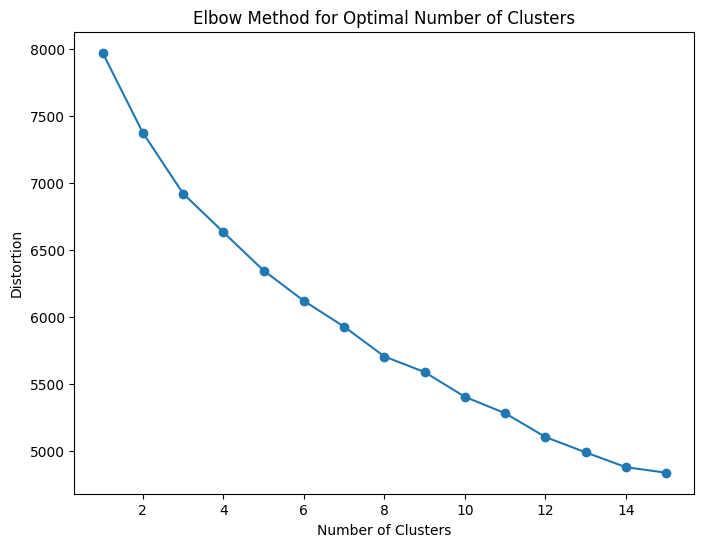

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Silhouette Score after PCA: 0.12246905913612097


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [12]:
if __name__ == "__main__":
    people_wiki_path = "/kaggle/input/people-wiki-data/people_wiki.csv"

    if os.path.exists(people_wiki_path):
        people_wiki = pd.read_csv(people_wiki_path)
        if "text" in people_wiki.columns:
            people_wiki["cleaned_text"] = people_wiki["text"].apply(preprocess_text)
        else:
            print("The dataset does not contain a 'text' column!")
            people_wiki = pd.DataFrame(columns=["cleaned_text"])
    else:
        print("People Wikipedia Dataset not found!")
        people_wiki = pd.DataFrame(columns=["cleaned_text"])

    # Load 20 Newsgroups Dataset
    categories = ["talk.religion.misc", "comp.graphics", "sci.space"]
    print("Loading 20 newsgroups dataset for categories:")
    print(categories)
    newsgroups = fetch_20newsgroups(subset="all", categories=categories, shuffle=False, remove=("headers", "footers", "quotes"))
    newsgroups_data = pd.DataFrame({"content": newsgroups.data})
    newsgroups_data["cleaned_text"] = newsgroups_data["content"].apply(preprocess_text)

    # Combine datasets for clustering
    combined_text = pd.concat([people_wiki["cleaned_text"], newsgroups_data["cleaned_text"]], ignore_index=True)

    # Feature extraction
    tfidf_features, tfidf_vectorizer = extract_features(combined_text)

    # Apply PCA
    pca = PCA(n_components=50, random_state=42)
    pca_features = pca.fit_transform(tfidf_features.toarray())

    # Determine optimal number of clusters
    determine_optimal_clusters(pca_features)

    # K-Means Clustering on PCA-transformed features
    num_clusters = 10  # Example: Adjust based on requirements
    kmeans_clusters, kmeans_model = kmeans_clustering(pca_features, num_clusters)
    silhouette_kmeans = evaluate_clustering(pca_features, kmeans_clusters)
    print(f"K-Means Silhouette Score after PCA: {silhouette_kmeans}")

    # Visualization
    visualize_clusters(pca_features, kmeans_clusters, method="pca")


In [9]:
# if __name__ == "__main__":
#     people_wiki_path = "/kaggle/input/people-data/people_wiki.csv"

#     if os.path.exists(people_wiki_path):
#         people_wiki = pd.read_csv(people_wiki_path)
#         people_wiki["cleaned_text"] = people_wiki["text"].apply(preprocess_text)
#     else:
#         print("People Wikipedia Dataset not found!")

#     # Load 20 Newsgroups Dataset
#     categories = ["talk.religion.misc", "comp.graphics", "sci.space"]
#     print("Loading 20 newsgroups dataset for categories:")
#     print(categories)
#     newsgroups = fetch_20newsgroups(subset="all", categories=categories, shuffle=False, remove=("headers", "footers", "quotes"))
#     newsgroups_data = pd.DataFrame({"content": newsgroups.data})
#     newsgroups_data["cleaned_text"] = newsgroups_data["content"].apply(preprocess_text)

#     # Combine datasets for clustering
#     combined_text = pd.concat([people_wiki["cleaned_text"], newsgroups_data["cleaned_text"]], ignore_index=True)

#     # Feature extraction
#     tfidf_features, tfidf_vectorizer = extract_features(combined_text)

#     # K-Means Clustering
#     num_clusters =   # Example: Adjust based on requirements
#     kmeans_clusters, kmeans_model = kmeans_clustering(tfidf_features, num_clusters)
#     silhouette_kmeans = evaluate_clustering(tfidf_features, kmeans_clusters)
#     print(f"K-Means Silhouette Score: {silhouette_kmeans}")

#     # # Hierarchical Clustering
#     # hierarchical_clusters, hierarchical_model = hierarchical_clustering(tfidf_features, num_clusters)
#     # silhouette_hierarchical = evaluate_clustering(tfidf_features, hierarchical_clusters)
#     # print(f"Hierarchical Clustering Silhouette Score: {silhouette_hierarchical}")

#     # # GMM Clustering
#     # gmm_clusters, gmm_model = gmm_clustering(tfidf_features, num_clusters)
#     # silhouette_gmm = evaluate_clustering(tfidf_features, gmm_clusters)
#     # print(f"GMM Silhouette Score: {silhouette_gmm}")

#     # # Visualization
#     # visualize_clusters(tfidf_features, kmeans_clusters, method="tsne")
#     # visualize_clusters(tfidf_features, gmm_clusters, method="pca")


Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Silhouette Score: 0.013303799762404984
